# Exploratory analysis

Here we take a look at the stanford-hatespeech dataset
and try to extract and visualize its main characteristics.

This dataset was built using snorkel and it's up and coming webapp sculpt.
Please ask for more information :)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from wordcloud import WordCloud
from collections import Counter

%matplotlib inline

Let's load Spacy's language model (English-medium).
This will take 10-20 seconds.

*What is [Spacy](https://spacy.io/)? Link to documentation: https://spacy.io/usage*

In [13]:
nlp = spacy.load("en_core_web_md")

The data is stored in a CSV file. Let's load it to a pandas dataframe:

In [14]:
df = pd.read_csv("../data/processed/stanford.csv")

What does the data look like?

In [15]:
df.head()

,text,label
0,The new Doras cute af,0
1,@minniemonikive well,0
2,Rolou o skank,1
3,@AOC https//t.co/lbNOwMK1p2,1
4,@tangletorn We will be killed by a snake 3,0


In [16]:
df.shape

(31014, 2)

Records with label=1 *are misogynistic*, with label=0 are not.

What's the positive vs negative label distribution?

In [17]:
df['label'].mean()

0.6365189914232282

In [18]:
df['label'].sum()

19741

Around 64% of the tweets are mysoginistic, which amounts to 19741 total tweets.
Let's look at a couple examples.

misogynistic:

In [19]:
df[df['label']==1].iloc[41, 0]

"@JessicaValenti That's a ship I'd upvote."

Non-Misogynistic:

In [20]:
df[df['label']==0].iloc[21, 0]

"@Lstedmanbryce @NicolaSturgeon Someone on here said to me yesterday that the Brexit Party don't care about Scotland. You are proving them wrong Louis. Very sad and shocking statistics that you have raised. I hope you receive a worthy response about your concerns."

Now we parse the text and create tokens along with their properties.
This may take a minute.

In [21]:
%%time
docs = list(nlp.pipe(df['text']))

CPU times: user 1min 43s, sys: 8.94 s, total: 1min 52s
Wall time: 1min 52s


Now we have a Spacy *Document*, that can be used to inspect tokens attributes and other linguistic features.

In [22]:
docs[0]  # This is one Spacy Document

The new Doras cute af

In [23]:
# Is the token a stopword?
docs[0][0].is_stop

True

In [24]:
# What are the entities in the document?
docs[0].ents

(Doras,)

In [25]:
# Accessing the actual text string is achieved with the `.text` attribute
docs[1][0].text[0]

'@'

### Stopword removal

*Stopwords* such as punctuations, very common words (such as *a*, *the*), or extra spaces
generally only add noise.
Removing them allows one to focus on less common and hopefully more important words.

Here we remove also mentions (e.g. `@AOC`) and URLs.

In [26]:
def filter_punct_space_stop(doc):
    filtered = []
    for token in doc:
        if (
            token.is_stop
            or token.is_punct
            or token.is_space
            or token.text.startswith("@")
            or token.text.startswith("https")
        ):
            continue
        filtered.append(token.text.lower())
    return filtered

In [27]:
tokens_no_stopwords = list(map(filter_punct_space_stop, docs))
tokens_no_stopwords[:2]

[['new', 'doras', 'cute', 'af'], []]

In [28]:
number_of_tokens = list(map(len, tokens_no_stopwords))
number_of_tokens[:5]

[4, 0, 3, 1, 3]

In [29]:
df['tokens'] = tokens_no_stopwords

In [30]:
df.head()

,text,label,tokens
0,The new Doras cute af,0,"[new, doras, cute, af]"
1,@minniemonikive well,0,[]
2,Rolou o skank,1,"[rolou, o, skank]"
3,@AOC https//t.co/lbNOwMK1p2,1,[lbnowmk1p2]
4,@tangletorn We will be killed by a snake 3,0,"[killed, snake, 3]"


### Top words

The most common words in tweets might reveal differences between misogynistic
and non-misogynistic speech.

In [31]:
df_msgn = df[df['label']==1]
df_non_msgn = df[df['label']==0]

In [32]:
count_msgn = Counter()

In [33]:
for idx, toks in df_msgn['tokens'].iteritems():
    for token in toks:
        count_msgn[token] += 1

In [34]:
count_msgn.most_common(10)

[('bitch', 9022),
 ('whore', 2620),
 ('nt', 2215),
 ('like', 2136),
 ('m', 1899),
 ('dyke', 1783),
 ('fucking', 1654),
 ('dirty', 1130),
 ('s', 1049),
 ('u', 958)]

In [35]:
count_non_msgn = Counter()

In [36]:
for idx, toks in df_non_msgn['tokens'].iteritems():
    for token in toks:
        count_non_msgn[token] += 1

In [37]:
count_non_msgn.most_common(10)

[('killed', 1937),
 ('dirty', 1473),
 ('nt', 1233),
 ('people', 1054),
 ('like', 942),
 ('trump', 704),
 ('amp', 599),
 ('know', 533),
 ('right', 516),
 ('s', 485)]

In [38]:
# Here order is important
labels = ("Misogyny", "No Misogyny")
counters = (count_msgn, count_non_msgn)
most_common = {}
for label, counter in zip(labels, counters):
    most_common[label] = {}
    most_common[label]['total_number_of_words'] = len(counter)
    most_common[label]['top_words'] = [w for (w, c) in counter.most_common(10)]
    most_common[label]['counts'] = [c for (w, c) in counter.most_common(10)]

In [39]:
most_common

{'Misogyny': {'total_number_of_words': 29526,
  'top_words': ['bitch',
   'whore',
   'nt',
   'like',
   'm',
   'dyke',
   'fucking',
   'dirty',
   's',
   'u'],
  'counts': [9022, 2620, 2215, 2136, 1899, 1783, 1654, 1130, 1049, 958]},
 'No Misogyny': {'total_number_of_words': 21862,
  'top_words': ['killed',
   'dirty',
   'nt',
   'people',
   'like',
   'trump',
   'amp',
   'know',
   'right',
   's'],
  'counts': [1937, 1473, 1233, 1054, 942, 704, 599, 533, 516, 485]}}

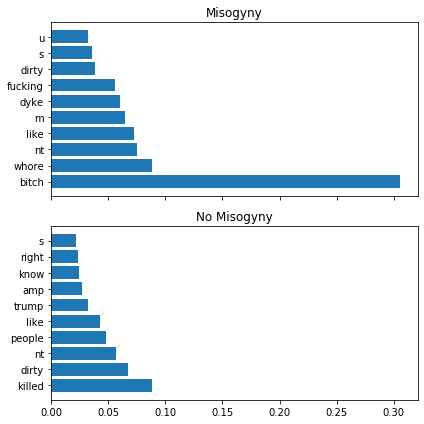

In [40]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
for label, ax in zip(labels, axes):
    ax.set_title(label)
    word_ratio = np.array(most_common[label]['counts']) / most_common[label]['total_number_of_words']
    ax.barh(most_common[label]['top_words'], word_ratio);
plt.tight_layout()

### Wordcloud
http://amueller.github.io/word_cloud/

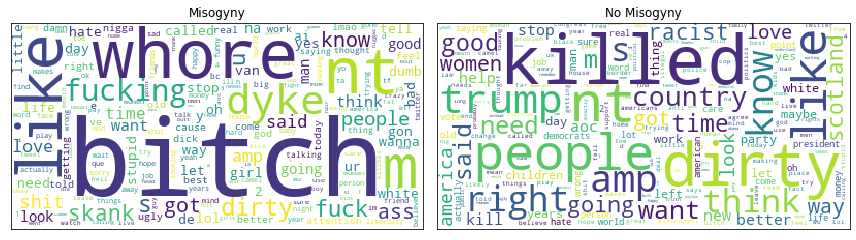

In [41]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 8))
for label, ax, frequencies in zip(labels, axes, counters):
    ax.set_title(label)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    wc = WordCloud(background_color='white').generate_from_frequencies(
        frequencies,
    )
    ax.imshow(wc)
plt.tight_layout()

### Tweets length

Here we compare the length of tweets measured as their total number of characters.
The histograms show a normalized density.

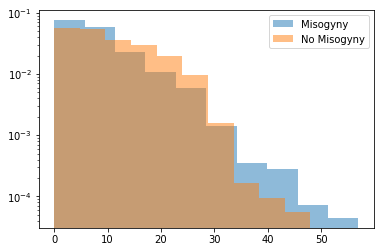

In [42]:
plt.hist(df_msgn['tokens'].apply(len), density=True, alpha=.5, label="Misogyny")
plt.hist(df_non_msgn['tokens'].apply(len), density=True, alpha=.5, label="No Misogyny")
plt.yscale('log')
plt.legend();

It looks like misogynistic tweets tend to use more characters.